# Training UNet for drop segmentation

In [1]:
import torch
from checkpoints import *

In [2]:
config = {
    "lr": 5e-4,
    "batch_size": 16,
    "epochs": 20,
    "threshold": 0.3,
    "init_from_checkpoint": True,
    "image_dir": '../../data/stereo/train/image',
    "mask_dir": '../../data/stereo/train/mask',
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "checkpoint_dir": "checkpoints",
    "checkpoint": None, # if None loads last saved checkpoint
    "print_model": False
}
print(f"Training using {config['device']}")

Training using cuda


In [3]:
# Load train and val datasets and prepare loaders

from torch.utils.data import DataLoader
import importlib
from dataset import WaterDropDataset
dataset = WaterDropDataset(
    image_dir=config["image_dir"],
    mask_dir=config["mask_dir"],
    threshold=config["threshold"],
    crop_shape=(256, 256)
)

assert dataset, "Dataset is empty!"

train_dataset, val_dataset = dataset.random_split(0.1)
train_loader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config["batch_size"],
    shuffle=True
)

print (f'Loaded {len(dataset)} images\n')
print (f'Train: {len(train_dataset)} images, {len(train_loader)} batches')
print (f'Val: {len(val_dataset)} images, {len(val_loader)} batches')

Loaded 678 images

Train: 611 images, 39 batches
Val: 67 images, 5 batches


In [4]:
# Load model, loss function and optimizer
from torch import nn
from unet import UNet
from unet import init_weights
from pathlib import Path

model = UNet(3).to(config['device'])

# Load or fill weights
# And set the start_epoch of model
if config["init_from_checkpoint"]:
    if config["checkpoint"] is None:
        path = last_checkpoint(config["checkpoint_dir"])
    else:
        path = Path(config["checkpoint_dir"], config["checkpoint"])     
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model_state_dict"])
    print(f"Loaded parameters from '{path}'")
    print_checkpoint(checkpoint)
    start_epoch = checkpoint["epochs"]
else:
    init_weights(model, torch.nn.init.normal_, mean=0., std=1)
    print("Randomly initiated parameters")
    start_epoch = 0

# Set optimizer & loss_fn
optimizer = torch.optim.Adam(params=model.parameters(), lr=config['lr'])

loss_fn = torch.nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler()

layers = model.train()
if config["print_model"]:
    print(layers)

Loaded parameters from 'checkpoints/UNetAdamBCEt37v35e49.pt'
Epochs:  50
Train loss:  0.3765500883261363
Valid loss:  0.35220298171043396


In [5]:
def check_accuracy_and_save(model, optimizer, loss_fn, epoch, train_loss):
    model.eval()

    losses = []
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(config['device'])
            y = y.to(config['device'])

            pred = model(x)
            loss = loss_fn(pred, y)
            losses.append(loss.item())
            
            smooth = 0.01
    mean_loss = sum(losses) / len(losses)
    print(f"Valid loss: {mean_loss}")
    model.train()

    save_checkpoint(
        config["checkpoint_dir"],
        model,
        optimizer,
        loss_fn,
        epoch,
        train_loss,
        mean_loss
    )

In [6]:
from tqdm.notebook import tqdm
from sys import stdout
def train():
    for epoch in range(config['epochs']):
        epoch += start_epoch
        print("Epoch", epoch)
        
        loader = tqdm(train_loader)
        losses = []
        
        for image, gt in loader:
            image = image.to(config['device'])
            gt = gt.float().to(config['device'])
            with torch.cuda.amp.autocast():
                pred = model(image)
                loss = loss_fn(pred, gt)
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss = loss.item()
            losses.append(train_loss)
            loader.set_postfix(loss=train_loss)

        mean_loss = sum(losses) / len(losses)
        print("Train loss:", mean_loss)
        check_accuracy_and_save(
            model, 
            optimizer,
            loss_fn,
            epoch, 
            mean_loss)

In [ ]:
train()

Epoch 50


  0%|          | 0/39 [00:00<?, ?it/s]

# Estimation

In [8]:
def predict(model, x, y, binary_map=True, binary_threshold=0.4):
    image_np = x.detach().numpy()[0][0]
    gt_np = y.detach().numpy()[0][0]

    model.eval()
    with torch.no_grad():
        x = x.to(config['device'])
        y = y.to(config['device'])

        pred = torch.sigmoid(model(x))
    model.train()
    pred_np  = pred.cpu().detach().numpy()[0][0]
    if binary_map:
        pred_np = pred_np >= binary_threshold
    return image_np, gt_np, pred_np

In [9]:
def plot_prediction(dataset, idx, binary_map=True, binary_threshold=0.42):
    x, y = val_dataset[idx]
    x = torch.stack([x])
    y = torch.stack([y])
    x, y, pred = predict(model, x, y, binary_map, binary_threshold)
    from matplotlib import pyplot as plt
    fig, axs = plt.subplots(1, 3, figsize=(17, 10))
    axs[0].imshow(x, cmap='gray')
    axs[1].imshow(y, cmap='gray')
    axs[2].imshow(pred, cmap='gray')

Index: 5


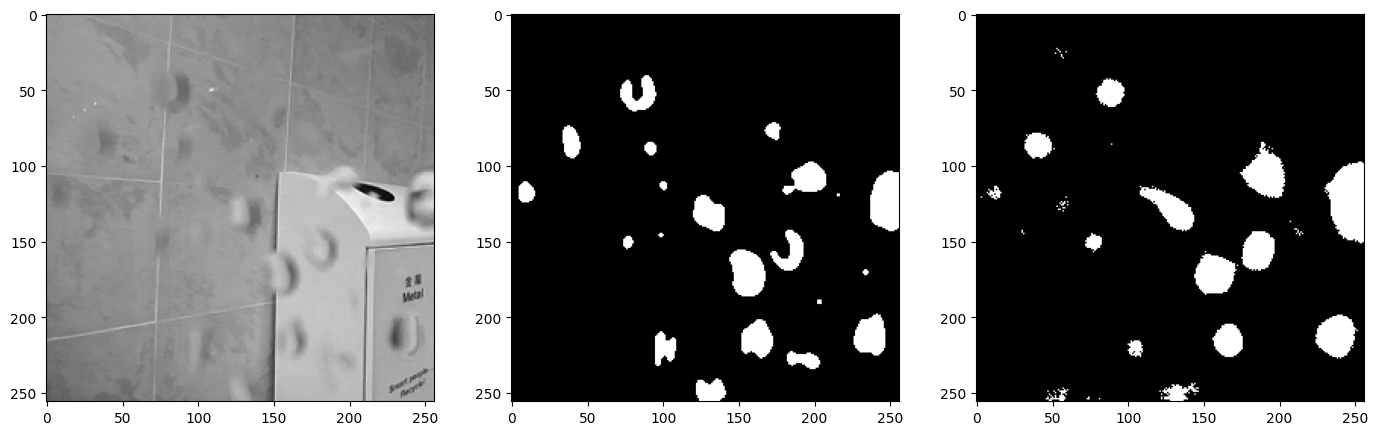

In [10]:
# Get prediction for random image and crop
from random import randint
idx = randint(0, len(val_dataset)-1)
print("Index:", idx)
plot_prediction(val_dataset, idx, binary_map=True)

In [11]:
import importlib
import checkpoints
importlib.reload(checkpoints)
from checkpoints import *
# Clear checkpoints by condition
#clear_checkpoints(config["checkpoint_dir"], condition=lambda ch: ch["val_loss"] > 0.37, save_last=1)

Nothing to remove


In [12]:
!ls -la checkpoints

total 1091624
drwxrwsr-x 2 kondrashov students      4096 Aug  5 20:03 .
drwxrwsr-x 5 kondrashov students      4096 Aug  5 20:32 ..
-rw-rw-r-- 1 kondrashov students 372596781 Aug  5 20:03 UNetAdamBCEt36v35e47.pt
-rw-rw-r-- 1 kondrashov students 372596781 Aug  5 20:03 UNetAdamBCEt36v36e48.pt
-rw-rw-r-- 1 kondrashov students 372596781 Aug  5 20:03 UNetAdamBCEt37v35e49.pt
